In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DIRECTORY = './data/'
categories = pd.read_csv(DIRECTORY + 'item_categories.csv')
items = pd.read_csv(DIRECTORY + 'items.csv')
shops = pd.read_csv(DIRECTORY + 'shops.csv')
train = pd.read_csv(DIRECTORY + 'sales_train.csv')
test = pd.read_csv(DIRECTORY + 'test.csv')

# 1. Why is predicting last month's sales trash?

In [3]:
train_cleaned = train.copy()
train_cleaned['date'] = pd.to_datetime(train_cleaned['date'], format='%d.%m.%Y')
train_cleaned = train_cleaned.drop(columns=['date_block_num', 'item_price'])
train_cleaned['month'] = train_cleaned['date'].dt.to_period('M')

In [4]:
# prediction of previous month
import statsmodels.api as sm 

monthly_sales = train_cleaned.groupby(by=['shop_id', 'item_id', 'month'])['item_cnt_day'].sum().to_frame('monthly_sales').reset_index()
monthly_sales = monthly_sales.sort_values(by=['month', 'shop_id', 'item_id'])

monthly_sales['previous_month_sales'] = monthly_sales.groupby(['shop_id', 'item_id'])['monthly_sales'].shift(1)
monthly_sales['mse'] = (np.clip(monthly_sales['monthly_sales'], 0, 20) - np.clip(monthly_sales['previous_month_sales'], 0, 20))**2
monthly_sales = monthly_sales.dropna()

high_error = monthly_sales[monthly_sales['mse'] > np.quantile(monthly_sales['mse'], 0.9)]
high_error

,shop_id,item_id,month,monthly_sales,previous_month_sales,mse
3,0,32,2013-02,10.0,6.0,16.0
7,0,35,2013-02,14.0,1.0,169.0
25,0,98,2013-02,5.0,25.0,225.0
60,0,556,2013-02,4.0,9.0,25.0
95,0,963,2013-02,2.0,7.0,25.0
...,...,...,...,...,...,...
1596195,59,9356,2015-10,1.0,5.0,16.0
1598774,59,12021,2015-10,2.0,7.0,25.0
1602208,59,15238,2015-10,5.0,1.0,16.0
1602252,59,15255,2015-10,1.0,5.0,16.0


<Axes: xlabel='monthly_sales', ylabel='previous_month_sales'>

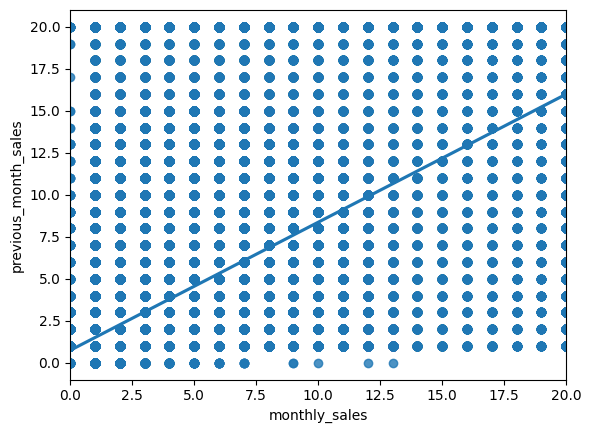

In [8]:
sns.regplot(x=np.clip(monthly_sales['monthly_sales'], 0, 20), y=np.clip(monthly_sales['previous_month_sales'], 0, 20))